# 1. Libraries

In [35]:
import numpy as np
import pandas as pd
from scipy.signal import correlate
import plotly.graph_objects as go

# 2. Load data

In [36]:
merged = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/external/aisp_local_nivel_merged.csv', index_col=0, parse_dates=True)

# 3. Normalization

In [37]:
merged_copy = merged.copy()
merged_copy['aisp_std'] = (merged_copy['aisp'] - merged_copy['aisp'].mean()) / merged['aisp'].std()
merged_copy['nivel_std'] = (merged_copy['nivel'] - merged_copy['nivel'].mean()) / merged['nivel'].std()
merged_real=merged_copy[['aisp', 'nivel']]
merged_std=merged_copy[['aisp_std', 'nivel_std']]

# 4. Cross-Correlation

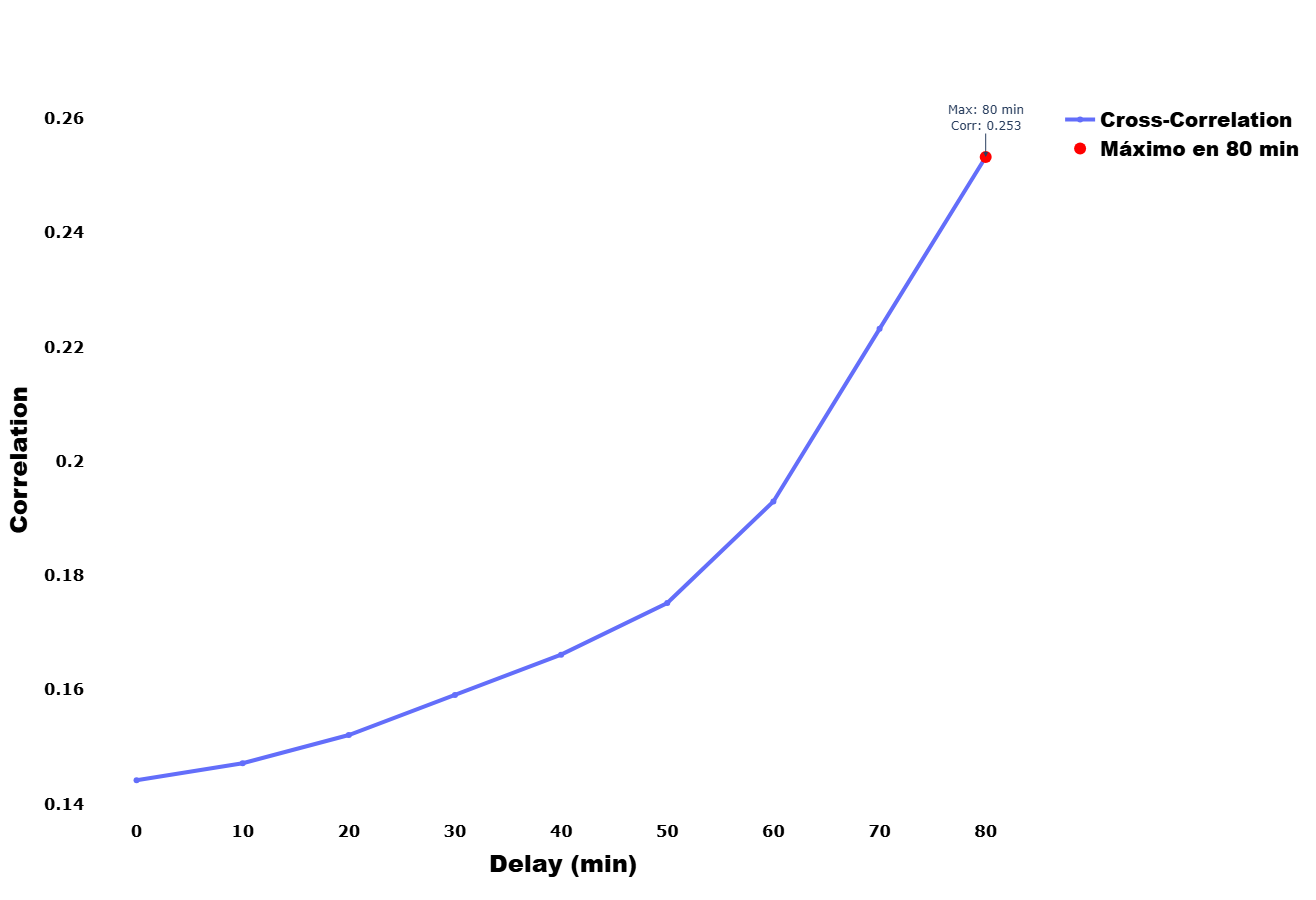

In [39]:
# Calcular la correlación cruzada
x = merged_std['nivel_std'].values
y = merged_std['aisp_std'].values

corr = correlate(x, y, mode='full')
lags = np.arange(-len(x) + 1, len(x))

# Normalización
norm_factor = np.array([len(x) - abs(lag) for lag in lags])
corr_norm = corr / norm_factor

# Definir el rango de lags en minutos
lags_minutes = lags * 10

# Filtrar los lags entre los valores de retardo deseados
MIN_DELAY_MINUTES = 0  
MAX_DELAY_MINUTES = 80 

mask = (lags_minutes >= MIN_DELAY_MINUTES) & (lags_minutes <= MAX_DELAY_MINUTES)
lags_minutes_filtered = lags_minutes[mask]
corr_norm_filtered = corr_norm[mask]

# Encontrar el índice de la máxima correlación
best_idx = np.argmax(np.abs(corr_norm_filtered))
best_lag_minutes = lags_minutes_filtered[best_idx]
best_corr = corr_norm_filtered[best_idx]

# Crear la figura
fig = go.Figure()

# Agregar la serie de correlación cruzada
fig.add_trace(go.Scatter(
    x=lags_minutes_filtered,
    y=corr_norm_filtered,
    mode='lines+markers',
    name='Cross-Correlation',
    line=dict(width=4)  # Engrosar la línea
))

# Agregar el punto máximo de la correlación
fig.add_trace(go.Scatter(
    x=[best_lag_minutes],
    y=[best_corr],
    mode='markers',
    marker=dict(color='red', size=12),
    name=f'Máximo en {best_lag_minutes} min',
    text=[f"{best_lag_minutes} min\n{best_corr:.3f}"],
    
    
))

# Anotación para el valor máximo
fig.add_annotation(
    x=best_lag_minutes,
    y=best_corr,
    text=f"Max: {best_lag_minutes} min<br>Corr: {best_corr:.3f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    bgcolor="white"
)

# Actualizar el layout
fig.update_layout(
    xaxis_title="Delay (min)",
    yaxis_title="Correlation",
    plot_bgcolor='white',
    paper_bgcolor='white',
    autosize=False,
    width=900,  
    height=900,
    legend=dict(
        font=dict(
            family="Arial Black",  
            size=20,              
            color="black"
        )
    ),
    xaxis=dict(
        title_font=dict(size=24, family="Arial Black", color="black"),  
        tickfont=dict(size=16, color="black",weight="bold")  
    ),
    yaxis=dict(
        title_font=dict(size=24, family="Arial Black", color="black"),  
        tickfont=dict(size=16, color="black",weight="bold")  
    )
)


fig.show()

In [22]:
# Crear DataFrame con los valores de delay y correlación normalizada
df_corr = pd.DataFrame({
    'Delay (min)': lags_minutes_filtered,
    'Cross-Correlation': corr_norm_filtered
})

# Renombrar la columna de delay como "silX"
df_corr['aisp'] = df_corr['Delay (min)'].apply(lambda x: f"sil{x}")

# Seleccionar y reordenar columnas
df_corr = df_corr[['aisp', 'Cross-Correlation']]

# Mostrar la tabla
print(df_corr)

    aisp  Cross-Correlation
0   sil0           0.138523
1  sil10           0.140335
2  sil20           0.144304
3  sil30           0.150528
4  sil40           0.156753
5  sil50           0.165286
6  sil60           0.183669
7  sil70           0.216137
8  sil80           0.248468
